In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px
import plotly.graph_objects as go

# load from github
train_data = pd.read_csv('https://raw.githubusercontent.com/cxxclk/ECOM90025/main/Data/train_data.csv')
print(train_data.head())

# set device to browser
import plotly.io as pio
pio.renderers.default = "vscode"

   ID         Y        X1        X2        X3        X4        X5        X6  \
0   0 -1.399091  1.174139  1.413109  0.164693 -1.067338  0.015324 -1.280970   
1   1  3.097990  0.208922  0.931231  0.838779  0.893483 -0.510555  0.900289   
2   2 -1.707346 -0.744982  0.962118  0.615392 -0.427943 -0.014912  1.138781   
3   3  0.610625 -0.170428 -1.361771  0.206042  0.623124  0.907441 -0.873814   
4   4 -0.689196 -0.858792  0.321308 -0.415649  1.014056 -0.522858  0.926634   

         X7        X8  ...       X41       X42       X43       X44       X45  \
0  0.489681 -0.371982  ... -0.115044 -2.580043 -0.812428  0.772820 -0.460444   
1 -0.042490  0.839400  ...  1.155635  0.673035 -0.438152 -0.001316 -0.761800   
2  1.159491  0.055467  ...  0.299277  1.387495 -0.007519 -0.464825  0.830986   
3  1.287383  0.901191  ...  1.209247  0.095866 -0.287905 -1.110714 -1.660352   
4 -0.390663  0.790054  ... -1.191989 -1.127448  0.246358  0.407769  1.132454   

        X46       X47       X48       X49   

In [2]:
# load from github
train_data = pd.read_csv('https://raw.githubusercontent.com/cxxclk/ECOM90025/main/Data/train_data.csv')
print(train_data.head())

   ID         Y        X1        X2        X3        X4        X5        X6  \
0   0 -1.399091  1.174139  1.413109  0.164693 -1.067338  0.015324 -1.280970   
1   1  3.097990  0.208922  0.931231  0.838779  0.893483 -0.510555  0.900289   
2   2 -1.707346 -0.744982  0.962118  0.615392 -0.427943 -0.014912  1.138781   
3   3  0.610625 -0.170428 -1.361771  0.206042  0.623124  0.907441 -0.873814   
4   4 -0.689196 -0.858792  0.321308 -0.415649  1.014056 -0.522858  0.926634   

         X7        X8  ...       X41       X42       X43       X44       X45  \
0  0.489681 -0.371982  ... -0.115044 -2.580043 -0.812428  0.772820 -0.460444   
1 -0.042490  0.839400  ...  1.155635  0.673035 -0.438152 -0.001316 -0.761800   
2  1.159491  0.055467  ...  0.299277  1.387495 -0.007519 -0.464825  0.830986   
3  1.287383  0.901191  ...  1.209247  0.095866 -0.287905 -1.110714 -1.660352   
4 -0.390663  0.790054  ... -1.191989 -1.127448  0.246358  0.407769  1.132454   

        X46       X47       X48       X49   

In [3]:
train_data = train_data.drop(columns=['ID'])
target_col = 'Y'
X = train_data.drop(columns=[target_col])
y = train_data[target_col]

In [4]:
# Split train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1920
Validation set size: 480


In [16]:
# Model I: LASSO
# Lasso with original features
lasso_1 = make_pipeline(StandardScaler(), 
                        LassoCV(cv=5, 
                                random_state=42,
                                n_jobs=-1,
                                alphas=np.logspace(-4, 4, 100))
    )
lasso_1.fit(X_train, y_train)
print(f"LASSO selected alpha: {lasso_1.named_steps['lassocv'].alpha_}")
y_val_pred_1 = lasso_1.predict(X_val)
rmse_1 = np.sqrt(mean_squared_error(y_val, y_val_pred_1))
r2_1 = r2_score(y_val, y_val_pred_1)
print(f"LASSO RMSE on training set: {np.sqrt(mean_squared_error(y_train, lasso_1.predict(X_train)))}")
print(f"LASSO RMSE on validation set: {rmse_1}")
print(f"LASSO R2 on validation set: {r2_1}")
# Print selected features and coefficients (in descending order of absolute value)
lasso_1_coef = lasso_1.named_steps['lassocv'].coef_
selected_features_1 = X_train.columns[lasso_1_coef != 0]
print(f"Number of selected features (LASSO): {len(selected_features_1)}")
print("Selected features (LASSO) and their coefficients:")
for feature, coef in sorted(zip(selected_features_1, lasso_1_coef[lasso_1_coef != 0]), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

# Generate plot for alpha vs MSE with CI
alpha_values = lasso_1.named_steps['lassocv'].alphas_
cv_scores = lasso_1.named_steps['lassocv'].mse_path_.mean(axis=1)  # Mean across CV folds (axis=1 for folds)
# Calculate confidence intervals (standard error across CV folds)
cv_std = lasso_1.named_steps['lassocv'].mse_path_.std(axis=1)  # Standard deviation across CV folds
df_cv = pd.DataFrame({
    'Alpha': alpha_values,
    'CV_MSE': cv_scores,
    'CV_STD': cv_std
})
# Create figure with error bars
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_cv['Alpha'],
    y=np.sqrt(df_cv['CV_MSE']),
    error_y=dict(type='data', array=np.sqrt(df_cv['CV_STD']), visible=True),
    mode='lines+markers',
    name='LASSO CV MSE'
))
fig.update_layout(
    title='LASSO: Alpha vs CV MSE with Confidence Intervals',
    xaxis_title='Alpha',
    yaxis_title='CV MSE',
    xaxis_type='log'
)

LASSO selected alpha: 0.03199267137797385
LASSO RMSE on training set: 2.702011142743279
LASSO RMSE on validation set: 2.5932441902293695
LASSO R2 on validation set: 0.5070289765773266
Number of selected features (LASSO): 41
Selected features (LASSO) and their coefficients:
X34: 1.1544261322496214
X41: 0.7132448302201304
X48: 0.5344539327703728
X26: 0.5165833331585328
X16: 0.5101500631266132
X10: 0.5022450897540173
X20: 0.470450627476136
X1: 0.46951055522278506
X46: 0.4552422066956969
X15: 0.4444077212043689
X30: 0.4342784899120027
X12: 0.42352560872462963
X22: 0.4204166862516463
X14: 0.3983069538535479
X5: 0.3755458937154258
X11: 0.35967310790268187
X43: 0.32540623055528184
X32: 0.29862290221489823
X21: 0.2527903694881733
X36: 0.2347615561574034
X38: 0.07940538889160698
X31: 0.0749631635074025
X18: 0.07199158259696829
X3: 0.06333459959890106
X19: 0.06301387908777785
X23: -0.054609708528622555
X25: 0.048580995584881874
X24: -0.04604843507999454
X40: 0.023201387376715232
X37: 0.022977475

In [19]:
# Polynomial Features with selected features from LASSO
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train[selected_features_1])
X_val_poly = poly.transform(X_val[selected_features_1])
print(f"Number of polynomial features: {X_train_poly.shape[1]}")

# Lasso with polynomial features
lasso_2 = make_pipeline(StandardScaler(), 
                        LassoCV(cv=5, 
                                random_state=42,
                                n_jobs=-1,
                                alphas=np.logspace(-4, 4, 100))
    )
lasso_2.fit(X_train_poly, y_train)
print(f"LASSO (poly) selected alpha: {lasso_2.named_steps['lassocv'].alpha_}")
y_val_pred_2 = lasso_2.predict(X_val_poly)
rmse_2 = np.sqrt(mean_squared_error(y_val, y_val_pred_2))
r2_2 = r2_score(y_val, y_val_pred_2)
print(f"LASSO (poly) RMSE on training set: {np.sqrt(mean_squared_error(y_train, lasso_2.predict(X_train_poly)))}")
print(f"LASSO (poly) RMSE on validation set: {rmse_2}")
print(f"LASSO (poly) R2 on validation set: {r2_2}")
# Print selected features and coefficients (in descending order of absolute value)
lasso_2_coef = lasso_2.named_steps['lassocv'].coef_
selected_features_2 = np.array(poly.get_feature_names_out(selected_features_1))[lasso_2_coef != 0]
print(f"Number of selected features (LASSO poly): {len(selected_features_2)}")
print("Selected features (LASSO poly) and their coefficients:")
for feature, coef in sorted(zip(selected_features_2, lasso_2_coef[lasso_2_coef != 0]), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")



Number of polynomial features: 13243
LASSO (poly) selected alpha: 0.08111308307896872
LASSO (poly) RMSE on training set: 1.5321221306240445
LASSO (poly) RMSE on validation set: 1.8775301035194811
LASSO (poly) R2 on validation set: 0.7415905550129758
Number of selected features (LASSO poly): 315
Selected features (LASSO poly) and their coefficients:
X16 X30: 1.0414992085554944
X12 X15: 1.0158518502119274
X34: 0.9040889079746196
X10 X21 X31: 0.8487573909306108
X14 X21 X46: 0.7436817798511435
X41: 0.5457108432271053
X20: 0.3938973335381522
X48: 0.3929565275647761
X16: 0.3152167643598463
X14: 0.3060142465195045
X26^2: -0.2976850583023932
X30: 0.2897313027731293
X22: 0.2857455500157956
X15: 0.2792341424808663
X12: 0.2778279536273526
X46: 0.2773384966662181
X26: 0.27696969457395537
X34^2: 0.2697860085715165
X1: 0.2646093819270503
X26 X34^2: 0.24846419061878053
X10: 0.24011505322201782
X21: 0.2073208439637149
X11: 0.20710272763142198
X5: 0.2005019915960028
X32: 0.16723511673269353
X36: 0.1553

In [24]:
# Generate plot for alpha vs MSE with CI
print("Selected Alpha for LASSO (poly):", lasso_2.named_steps['lassocv'].alpha_)
alpha_values_2 = lasso_2.named_steps['lassocv'].alphas_
cv_scores_2 = lasso_2.named_steps['lassocv'].mse_path_.mean(axis=1)  # Mean across CV folds (axis=1 for folds)
# Calculate confidence intervals (standard error across CV folds)
cv_std_2 = lasso_2.named_steps['lassocv'].mse_path_.std(axis=1)  # Standard deviation across CV folds
df_cv_2 = pd.DataFrame({
    'Alpha': alpha_values_2,
    'CV_MSE': cv_scores_2,
    'CV_STD': cv_std_2
})
# Create figure with error bars
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=df_cv_2['Alpha'],
    y=np.sqrt(df_cv_2['CV_MSE']),
    error_y=dict(type='data', array=np.sqrt(df_cv_2['CV_STD']), visible=True),
    mode='lines+markers',
    name='LASSO (poly) CV MSE'
))
fig2.update_layout(
    title='LASSO (poly): Alpha vs CV MSE with Confidence Intervals',
    xaxis_title='Alpha',
    yaxis_title='CV MSE',
    xaxis_type='log'
)
fig2.show()

Selected Alpha for LASSO (poly): 0.08111308307896872


In [ ]:
# Do some fine-tuning if necessary
# LASSO with selected alpha
optimal_alpha = lasso_2.named_steps['lassocv'].alpha_
alpha_min = optimal_alpha * 0.1
alpha_max = optimal_alpha * 10
fine_alphas = np.logspace(np.log10(alpha_min), np.log10(alpha_max), 50)
lasso_2_tuned = make_pipeline(StandardScaler(), 
                               LassoCV(cv=5, 
                                       random_state=42,
                                       n_jobs=-1,
                                       alphas=fine_alphas 
    )
)
lasso_2_tuned.fit(X_train_poly, y_train)
print(f"LASSO (poly) selected alpha (tuned): {lasso_2_tuned.named_steps['lassocv'].alpha_}")
y_val_pred_2_tuned = lasso_2_tuned.predict(X_val_poly)
rmse_2_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_2_tuned))
r2_2_tuned = r2_score(y_val, y_val_pred_2_tuned)
print(f"LASSO (poly) RMSE on training set (tuned): {np.sqrt(mean_squared_error(y_train, lasso_2_tuned.predict(X_train_poly)))}")
print(f"LASSO (poly) RMSE on validation set (tuned): {rmse_2_tuned}")
print(f"LASSO (poly) R2 on validation set (tuned): {r2_2_tuned}")

LASSO (poly) selected alpha (tuned): 0.08501568772684732
LASSO (poly) RMSE on training set (tuned): 1.5615596940925769
LASSO (poly) RMSE on validation set (tuned): 1.8774602389768194
LASSO (poly) R2 on validation set (tuned): 0.7416097859395674


In [36]:
# Print selected features and coefficients (in descending order of absolute value)
lasso_2_tuned_coef = lasso_2_tuned.named_steps['lassocv'].coef_
selected_features_2_tuned = np.array(poly.get_feature_names_out(selected_features_1))[lasso_2_tuned_coef != 0]
print(f"Number of selected features (LASSO poly tuned): {len(selected_features_2_tuned)}")
print("Selected features (LASSO poly tuned) and their coefficients:")
for feature, coef in sorted(zip(selected_features_2_tuned, lasso_2_tuned_coef[lasso_2_tuned_coef != 0]), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")


Number of selected features (LASSO poly tuned): 275
Selected features (LASSO poly tuned) and their coefficients:
X16 X30: 1.0390942904365401
X12 X15: 1.013257836613407
X34: 0.9054391965346678
X10 X21 X31: 0.8497999219112724
X14 X21 X46: 0.7429880911305974
X41: 0.5475815362809036
X48: 0.397583460896131
X20: 0.3900850621914996
X16: 0.31619278801234346
X14: 0.3071194287987877
X26^2: -0.29593978068761423
X30: 0.2906641475802732
X22: 0.28743856383501193
X12: 0.2826688754538363
X15: 0.28183193311797167
X26: 0.27942928142310935
X46: 0.2781505379135773
X34^2: 0.26573957224560446
X1: 0.2642261676280966
X10: 0.24678671579206432
X26 X34^2: 0.24509524533315455
X11: 0.2091629113806215
X21: 0.2037185328149849
X5: 0.2021778530834242
X32: 0.16396226400502703
X36: 0.15645611587182237
X43: 0.1249122431806737
X26 X34: 0.12222148035504463
X11 X28^2: 0.1022169949569165
X5 X41^2: 0.08289388093579134
X25^2 X46: 0.08018060362576097
X22^2 X32: 0.06302686034511688
X1^3: 0.06252392079672979
X34 X47^2: 0.06128415

In [35]:
#  Generate plot for alpha vs MSE with CI
print("Selected Alpha for LASSO (tuned):", lasso_2_tuned.named_steps['lassocv'].alpha_)
alpha_values_tuned = lasso_2_tuned.named_steps['lassocv'].alphas_
cv_scores_tuned = lasso_2_tuned.named_steps['lassocv'].mse_path_.mean(axis=1)  # Mean across CV folds (axis=1 for folds)
# Calculate confidence intervals (standard error across CV folds)
cv_std_tuned = lasso_2_tuned.named_steps['lassocv'].mse_path_.std(axis=1)  # Standard deviation across CV folds
df_cv_tuned = pd.DataFrame({
    'Alpha': alpha_values_tuned,
    'CV_MSE': cv_scores_tuned,
    'CV_STD': cv_std_tuned
})
# Create figure with error bars
fig_tuned = go.Figure()
fig_tuned.add_trace(go.Scatter(
    x=df_cv_tuned['Alpha'],
    y=np.sqrt(df_cv_tuned['CV_MSE']),
    error_y=dict(type='data', array=np.sqrt(df_cv_tuned['CV_STD']), visible=True),
    mode='lines+markers',
    name='LASSO (poly, tuned) CV MSE'
))
fig_tuned.update_layout(
    title='LASSO (poly, tuned): Alpha vs CV MSE with Confidence Intervals',
    xaxis_title='Alpha',
    yaxis_title='CV MSE',
    xaxis_type='log'
)
fig_tuned.show()

Selected Alpha for LASSO (tuned): 0.08501568772684732


In [28]:
# MODEL II: LOWESS/LMM Prediction
# First let's check which features needs to be 'LOWESS'ed
from collections import defaultdict

# If a variable appears in both original and polynomial forms, we consider it for LOWESS 
# As LASSO suggests linear is not enough to capture its relationship with the target
selected_features = selected_features_2
var_forms = defaultdict(list)
for feat in selected_features:
    if '^2' in feat:
        var_name = feat.split('^')[0]
        var_forms[var_name].append('square')
    elif '^3' in feat:
        var_name = feat.split('^')[0]
        var_forms[var_name].append('cubic')
    else:
        var_forms[feat].append('original')

multi_selected_vars = [var for var, forms in var_forms.items() if len(forms) > 1 and 'original' in forms]
print("Multiple forms selected for LOWESS:", multi_selected_vars)


Multiple forms selected for LOWESS: ['X1', 'X5', 'X10', 'X12', 'X16', 'X20', 'X21', 'X22', 'X26', 'X30', 'X32', 'X34', 'X46', 'X26 X34', 'X36 X43']


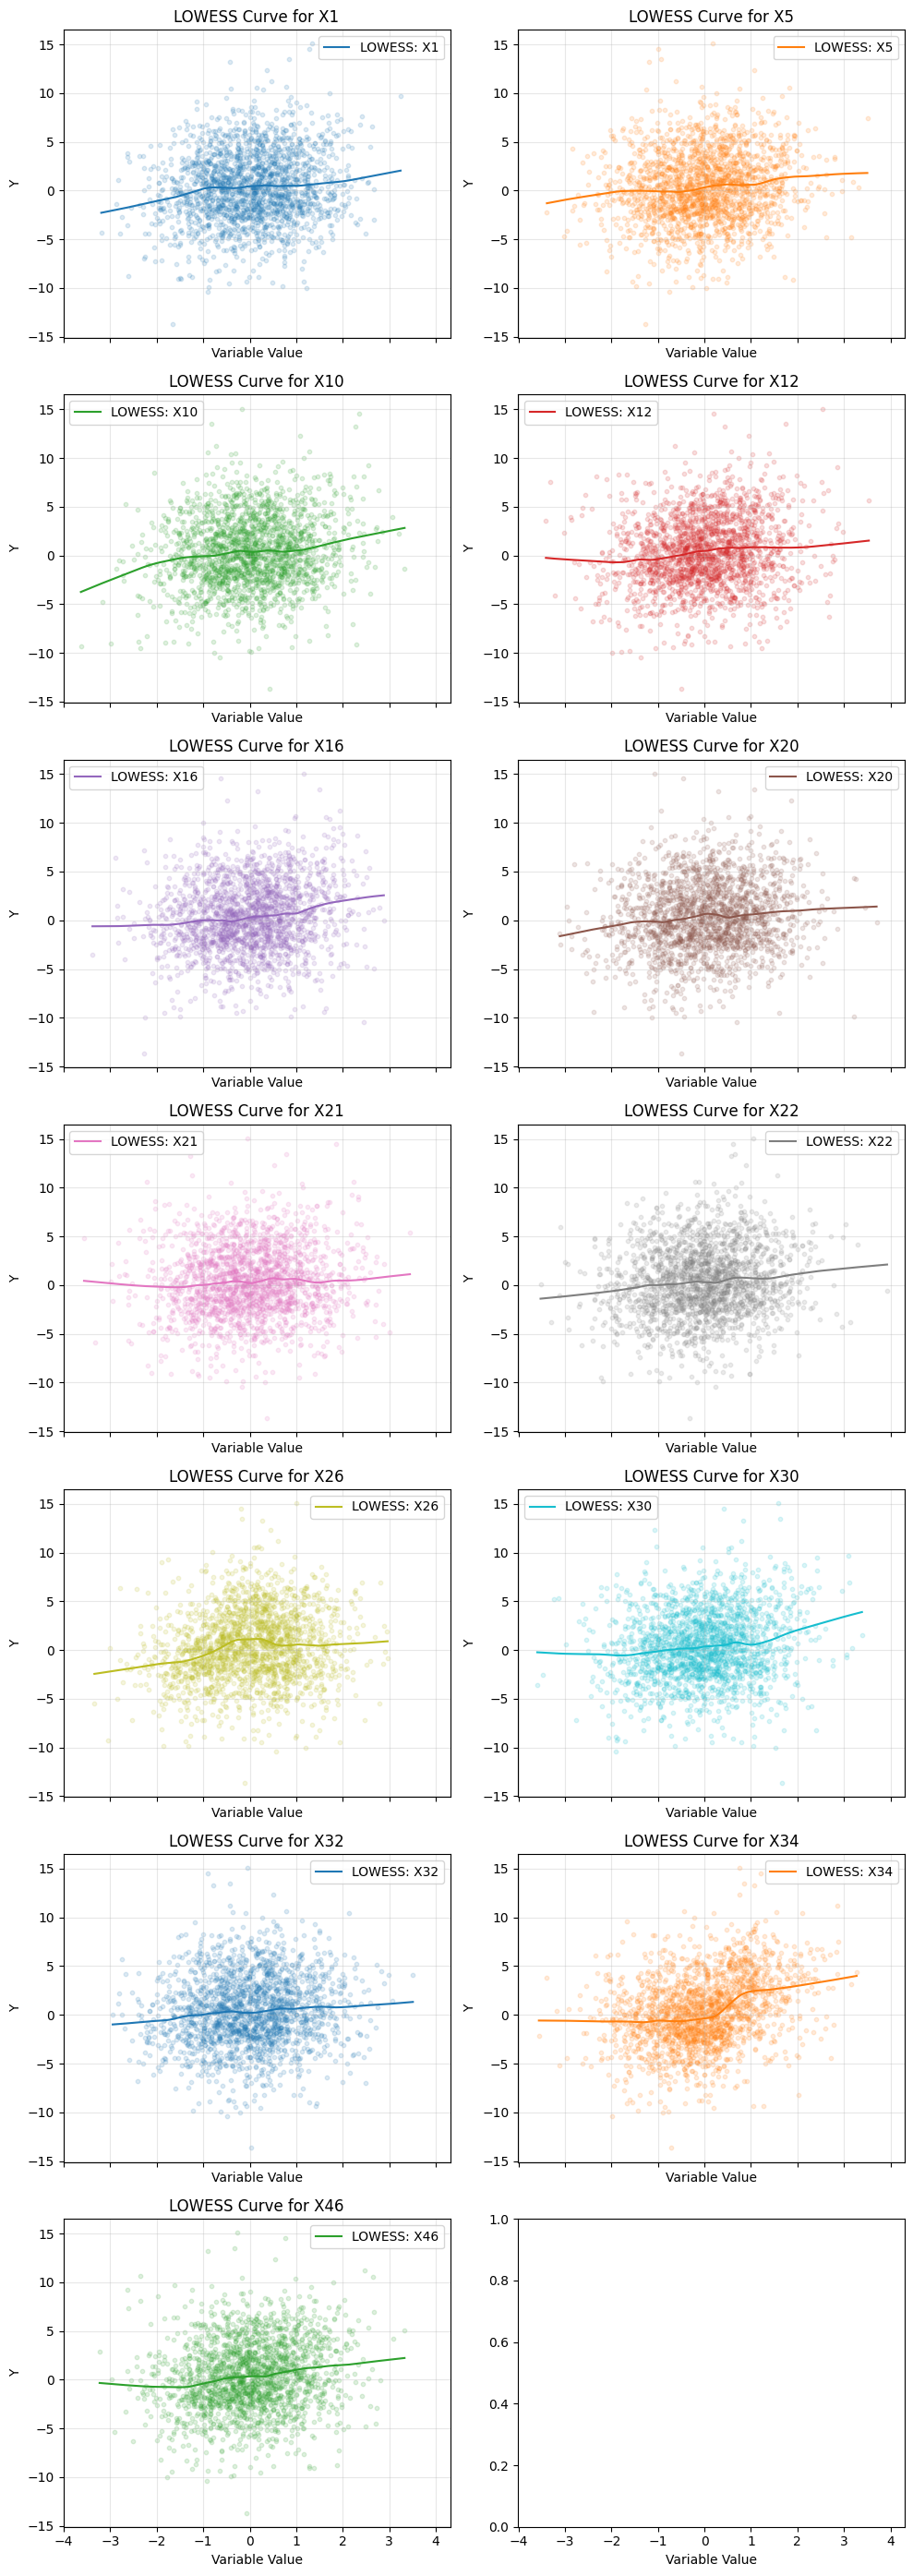

In [29]:
# Generate LOWESS plot for each variable
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

# Only keep variables that are columns in X_train
original_vars = [var for var in multi_selected_vars if var in X_train.columns]

# Define color palette
colors = plt.cm.tab10.colors

import math
nrows = math.ceil(len(original_vars) / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 4 * nrows), sharex=True)
for i, var in enumerate(original_vars):
    x_data = X_train[var].values
    y_data = y_train.values
    lowess_result = lowess(y_data, x_data, frac=0.3, return_sorted=True)
    axes.flat[i].plot(lowess_result[:, 0], lowess_result[:, 1], label=f'LOWESS: {var}', color=colors[i % len(colors)])
    axes.flat[i].scatter(x_data, y_data, alpha=0.15, s=10, color=colors[i % len(colors)])
    axes.flat[i].set_ylabel('Y')
    axes.flat[i].set_title(f'LOWESS Curve for {var}')
    axes.flat[i].legend()
    axes.flat[i].grid(True, alpha=0.3)
# Set xlabel for all axes
for ax in axes.flat:
    ax.set_xlabel('Variable Value')
plt.tight_layout()

# save figure
plt.savefig('lowess_curves.png')

In [ ]:
# Among these features, X34 is the most suspicious one that needs LOWESS
# X10, X30, X26 are also candidates but not as strong as X34

# Predict using LOWESS for each of them

lowess_vars  = ['X34','X10','X30','X26']
lowess_fracs = np.linspace(0.2, 0.4, 3)  # fracs to try

X_train_lowess = X_train.copy()
X_val_lowess   = X_val.copy()

def fit_lowess_and_interp(x_tr, y_tr, x_new, frac):
    # Fit once to get the ordered (x, yhat)
    # Choose return_sorted=False + argsort, or directly True; here use True for clarity
    res = lowess(endog=y_tr, exog=x_tr, frac=frac, return_sorted=True)
    x_sorted, y_sm = res[:,0], res[:,1]
    return np.interp(x_new, x_sorted, y_sm, left=y_sm[0], right=y_sm[-1]), (x_sorted, y_sm)

for var in lowess_vars:
    best = {"frac": None, "rmse": np.inf, "pred_tr": None, "pred_val": None}

    for frac in lowess_fracs:
        # Fit once to get the predictions for train/val
        yhat_tr, (x_sorted, y_sm) = fit_lowess_and_interp(X_train[var].values, y_train.values,
                                                          X_train[var].values, frac)
        yhat_val = np.interp(X_val[var].values, x_sorted, y_sm, left=y_sm[0], right=y_sm[-1])
        rmse_val = np.sqrt(mean_squared_error(y_val, yhat_val))
        if rmse_val < best["rmse"]:
            best.update(frac=frac, rmse=rmse_val, pred_tr=yhat_tr, pred_val=yhat_val)

    # 加入最优 LOWESS 特征
    X_train_lowess[f'LOWESS_{var}'] = best["pred_tr"]
    X_val_lowess[f'LOWESS_{var}']   = best["pred_val"]
    print(f"Selected LOWESS {var}  frac={best['frac']:.2f}  Val RMSE={best['rmse']:.4f}")

print("LOWESS features added:", [f'LOWESS_{v}' for v in lowess_vars])


Selected LOWESS X34  frac=0.40  Val RMSE=3.3835
Selected LOWESS X10  frac=0.40  Val RMSE=3.6667
Selected LOWESS X30  frac=0.40  Val RMSE=3.6772
Selected LOWESS X26  frac=0.20  Val RMSE=3.5713
LOWESS features added: ['LOWESS_X34', 'LOWESS_X10', 'LOWESS_X30', 'LOWESS_X26']


In [45]:
from scipy.optimize import nnls

# Use the correct variable names from your notebook
# y_val_pred_2_tuned is the LASSO polynomial tuned predictions
# Individual LOWESS predictions from the previous cell
base_preds_val = [y_val_pred_2_tuned]

# Add individual LOWESS predictions for each variable
for var in lowess_vars:
    lowess_col = f'LOWESS_{var}'
    if lowess_col in X_val_lowess.columns:
        base_preds_val.append(X_val_lowess[lowess_col].values)

P_val = np.column_stack(base_preds_val)

# 方案B：二层 Ridge（允许正负权重，通常更稳）
from sklearn.linear_model import RidgeCV
meta = RidgeCV(alphas=[1e-6, 1e-4, 1e-3, 1e-2, 1e-1], fit_intercept=False).fit(P_val, y_val)
w_ridge = meta.coef_
y_blend_val_ridge = meta.predict(P_val)

print(f"Ridge blending weights: {w_ridge}")
print(f"Ridge blended RMSE on validation set: {np.sqrt(mean_squared_error(y_val, y_blend_val_ridge))}")

Ridge blending weights: [1.11577506e+00 2.07820595e-01 1.17213872e-02 3.94475814e-04
 3.33556430e-01]
Ridge blended RMSE on validation set: 1.7677410027471272


In [52]:
# Load test data
test_data = pd.read_csv('https://raw.githubusercontent.com/cxxclk/ECOM90025/main/Data/test_data.csv')
test_ids = test_data['ID']
test_data_clean = test_data.drop(columns=['ID'])

# 1) Create polynomial features for test data using the same selected features
test_data_poly = poly.transform(test_data_clean[selected_features_1])

# 2) LASSO(poly) predictions on test data
pred_poly_test = lasso_2_tuned.predict(test_data_poly)

# 3) Generate LOWESS predictions for test data
# Combine full training data
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Get LOWESS predictions for test data using the same approach as training
test_data_lowess = test_data_clean.copy()

for var in lowess_vars:
	# Find the best fraction that was used during validation
	best = {"frac": None, "rmse": np.inf, "pred_test": None}
	
	for frac in lowess_fracs:
		# Fit LOWESS on full training data (X_full, y_full)
		yhat_tr_full, (x_sorted, y_sm) = fit_lowess_and_interp(
			X_full[var].values, y_full.values, X_full[var].values, frac
		)
		
		# Predict on test data
		yhat_test = np.interp(test_data_clean[var].values, x_sorted, y_sm, 
							 left=y_sm[0], right=y_sm[-1])
		
		# Use the same validation approach to select best frac
		yhat_val_check = np.interp(X_val[var].values, x_sorted, y_sm, 
								  left=y_sm[0], right=y_sm[-1])
		rmse_val_check = np.sqrt(mean_squared_error(y_val, yhat_val_check))
		
		if rmse_val_check < best["rmse"]:
			best.update(frac=frac, rmse=rmse_val_check, pred_test=yhat_test)
	
	# Add LOWESS predictions to test data
	test_data_lowess[f'LOWESS_{var}'] = best["pred_test"]
	print(f"Selected LOWESS {var} for test: frac={best['frac']:.2f}")

# Extract LOWESS predictions as individual arrays for blending
preds_lowess_test = []
for var in lowess_vars:
	preds_lowess_test.append(test_data_lowess[f'LOWESS_{var}'].values)

# 4) Assemble P_test and use w_ridge for blending
P_test = np.column_stack([pred_poly_test] + preds_lowess_test)

assert P_test.shape[1] == len(w_ridge), f"Number of base models ({P_test.shape[1]}) doesn't match weight length ({len(w_ridge)})"

y_test_blend = P_test @ w_ridge

# 5) Create submission
submission = pd.DataFrame({'ID': test_ids, 'Y': y_test_blend})
submission.to_csv('submission.csv', index=False)
print(f"Submission saved with {len(submission)} predictions")
print(f"Test predictions range: [{y_test_blend.min():.4f}, {y_test_blend.max():.4f}]")



Selected LOWESS X34 for test: frac=0.20
Selected LOWESS X10 for test: frac=0.40
Selected LOWESS X30 for test: frac=0.20
Selected LOWESS X26 for test: frac=0.20
Submission saved with 1600 predictions
Test predictions range: [-17.1699, 12.3194]
